In [2]:
from sklearn.ensemble import BaggingRegressor
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing
def prepros(train_file, test_file, ground_file):
    # read training data - It is the aircraft engine run-to-failure data.
    train_df = pd.read_csv(train_file, sep=" ", header=None)

    #remove the columns 26 and 27 because of NAN values
    train_df=train_df.loc[:,0:25]

    train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                         's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                         's15', 's16', 's17', 's18', 's19', 's20', 's21']

    train_df = train_df.sort_values(['id','cycle'])

    # read test data - It is the aircraft engine operating data without failure events recorded.
    test_df = pd.read_csv(test_file, sep=" ", header=None)

    #remove the columns 26 and 27 because of NAN values
    test_df=test_df.loc[:,0:25]

    test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                         's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                         's15', 's16', 's17', 's18', 's19', 's20', 's21']

    test_df = test_df.sort_values(['id','cycle'])

    #read ground truth data - It contains the information of true remaining cycles for each engine in the testing data.
    truth_df = pd.read_csv(ground_file, sep=" ", header=None)

    #remove the columns 1 because of NAN values
    truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)
    truth_df.columns = ['cycle']

    # Data Labeling - generate column RUL(Remaining Usefull Life or Time to Failure)
    ##TRAINING DATASET
    rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
    rul.columns = ['id', 'max']

    train_df = train_df.merge(rul, on=['id'], how='left')

    train_df['RUL'] = train_df['max'] - train_df['cycle']
    train_df.drop('max', axis=1, inplace=True)

    # generate label columns for training data
    # we will only make use of "label1" for binary classification, 
    # while trying to answer the question: is a specific engine going to fail within w1 cycles?
    w1 = 30
    w0 = 15
    train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )

    train_df['label2'] = train_df['label1']
    train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2

    #check columns with repeated values: setting3, s1, s5, s10, s16,s18,s19
    train_df.apply(lambda x: x.nunique())
    train_df.drop(train_df.columns[[4,5,9,14,20,22,23]], axis=1, inplace=True)

    #TEST DATASET
    test_df.drop(test_df.columns[[4,5,9,14,20,22,23]], axis=1, inplace=True)
    test_df.apply(lambda x: x.nunique())

    # We use the ground truth dataset to generate labels for the test data.
    # generate column max for test data
    rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()

    rul.columns = ['id', 'max']
    truth_df.columns = ['more']
    truth_df['id'] = truth_df.index + 1
    truth_df['max'] = rul['max'] + truth_df['more']
    truth_df.drop('more', axis=1, inplace=True)

    # generate RUL for test data
    test_df = test_df.merge(truth_df, on=['id'], how='left')
    test_df['RUL'] = test_df['max'] - test_df['cycle']
    test_df.drop('max', axis=1, inplace=True)

    # generate label columns w0 and w1 for test data
    test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
    test_df['label2'] = test_df['label1']
    test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2

    # MinMax normalization (from 0 to 1)
    min_max_scaler = preprocessing.MinMaxScaler()

    ###TRAIN#####
    train_df['cycle_norm'] = train_df['cycle']
    cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
    norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                                 columns=cols_normalize, 
                                 index=train_df.index)

    join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
    train_df = join_df.reindex(columns = train_df.columns)

    ####TEST#####
    test_df['cycle_norm'] = test_df['cycle']
    test_df['id_norm'] = test_df['id']
    norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                                columns=cols_normalize, 
                                index=test_df.index)
    test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
    test_df = test_join_df.reindex(columns = test_df.columns)
    test_df = test_df.reset_index(drop=True)

    #### Generating input data
    # pick the feature columns 
    sequence_cols = train_df.columns.difference(['id','cycle','RUL','label1','label2'])

    # generate sequences and convert to numpy array
    X_train = train_df[sequence_cols]

    #obtain the last cycle data for each test battery
    test_df=test_df.loc[test_df.groupby('id').cycle.idxmax()]
    X_test = test_df[sequence_cols]
    # Generate labels
    y_train=train_df['RUL']
    y_test=test_df['RUL']
    return (X_train, y_train, X_test, y_test)

In [3]:
X_train_1, y_train_1, X_test_1, y_test_1 = prepros('train_FD001.txt', 'test_FD001.txt', 'RUL_FD001.txt')
X_train_2, y_train_2, X_test_2, y_test_2 = prepros('train_FD002.txt', 'test_FD002.txt', 'RUL_FD002.txt')
X_train_3, y_train_3, X_test_3, y_test_3 = prepros('train_FD003.txt', 'test_FD003.txt', 'RUL_FD003.txt')
X_train_4, y_train_4, X_test_4, y_test_4 = prepros('train_FD004.txt', 'test_FD004.txt', 'RUL_FD004.txt')

/Users/divishrengasamy/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Users/divishrengasamy/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Users/divishrengasamy/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Users/divishrengasamy/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [4]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1100, num = 10)]
# Number of features to consider at every split
max_features = [5,10,18]
# Minimum number of samples required to split a node
max_samples = [10,20,30]
# Minimum number of samples required at each leaf node
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_samples': max_samples,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100], 'max_features': [5, 10, 18], 'max_samples': [10, 20, 30], 'bootstrap': [True, False]}


In [6]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
br = BaggingRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
br_random_1 = RandomizedSearchCV(estimator = br, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
br_random_1.fit(X_train_1, y_train_1)
br_random_1.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   42.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.9min finished


{'bootstrap': True, 'max_features': 18, 'max_samples': 30, 'n_estimators': 400}

In [7]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
br = BaggingRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
br_random_2 = RandomizedSearchCV(estimator = br, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
br_random_2.fit(X_train_2, y_train_2)
br_random_2.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 11.1min finished


{'bootstrap': True, 'max_features': 18, 'max_samples': 30, 'n_estimators': 700}

In [8]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
br = BaggingRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
br_random_3 = RandomizedSearchCV(estimator = br, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
br_random_3.fit(X_train_3, y_train_3)
br_random_3.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   37.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  5.8min finished


{'bootstrap': False,
 'max_features': 10,
 'max_samples': 30,
 'n_estimators': 200}

In [9]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
br = BaggingRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
br_random_4 = RandomizedSearchCV(estimator = br, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
br_random_4.fit(X_train_4, y_train_4)
br_random_4.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 14.6min finished


{'bootstrap': False,
 'max_features': 18,
 'max_samples': 30,
 'n_estimators': 400}

In [14]:
def training_func(X_train_data, y_train_data,bootstrap_,max_features_,max_samples_,n_estimators_):
    clf=BaggingRegressor(n_estimators=n_estimators_,
                         bootstrap=bootstrap_, 
                         max_features=max_features_,
                         max_samples=max_samples_)
    start = time.time()
    clf.fit(X_train_data, y_train_data)
    end = time.time()
    training_time = end - start
    return (clf, training_time)

In [15]:
#{'bootstrap': True, 'max_features': 18, 'max_samples': 30, 'n_estimators': 400}
clf_1, training_time_1 = training_func(X_train_1, y_train_1, True, 18, 30, 400)
#{'bootstrap': True, 'max_features': 18, 'max_samples': 30, 'n_estimators': 700}
clf_2, training_time_2 = training_func(X_train_2, y_train_2, True, 18, 30, 700)
#{'bootstrap': False, 'max_features': 10, 'max_samples': 30, 'n_estimators': 200}
clf_3, training_time_3 = training_func(X_train_3, y_train_3, False, 10, 30, 200)
#{'bootstrap': False, 'max_features': 18, 'max_samples': 30, 'n_estimators': 400}
clf_4, training_time_4 = training_func(X_train_4, y_train_4, False, 18, 30, 400)

In [16]:
y_pred_1 = clf_1.predict(X_test_1)
y_pred_2 = clf_2.predict(X_test_2)
y_pred_3 = clf_3.predict(X_test_3)
y_pred_4 = clf_4.predict(X_test_4)

In [17]:
# Plot in blue color the predicted data and in green color the
# actual data to verify visually the accuracy of the model.
def plot_pred(y_pred, y_test):
    fig_verify = plt.figure(figsize=(10, 5))
    plt.plot(y_pred, color="blue")
    plt.plot(y_test.values, color="green")
    plt.title('prediction')
    plt.ylabel('value')
    plt.xlabel('row')
    plt.legend(['predicted', 'actual data'], loc='upper left')
    plt.show()
    fig_verify.savefig("model_RF_verify.png")

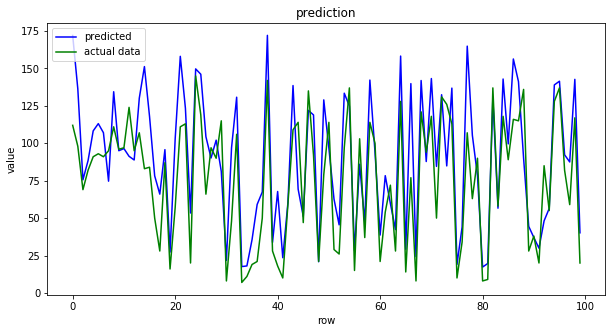

In [18]:
plot_pred(y_pred_1, y_test_1)

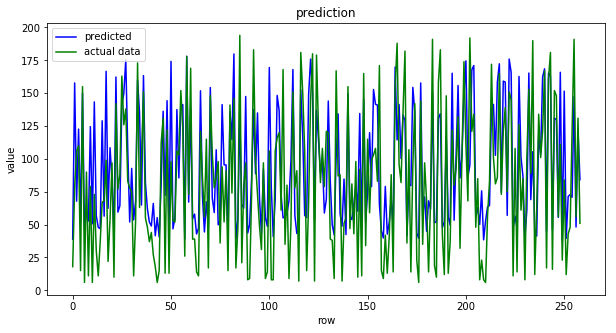

In [19]:
plot_pred(y_pred_2, y_test_2)

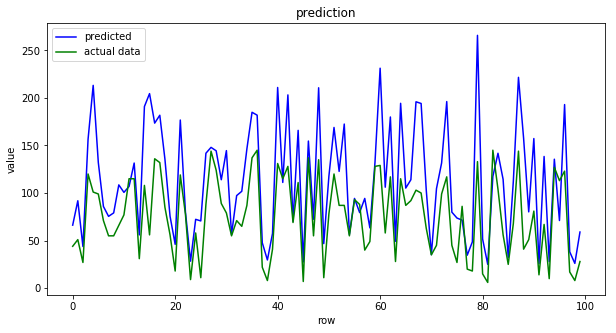

In [20]:
plot_pred(y_pred_3, y_test_3)

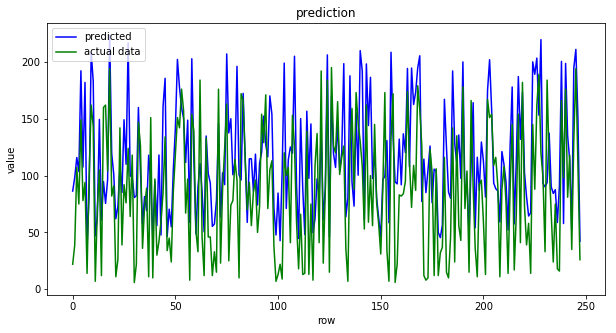

In [21]:
plot_pred(y_pred_4, y_test_4)

In [22]:
def scoring_function(true, pred):
    d = pred - true
    length = len(d)
    s = 0
    for i in range(length):
        if (d[i] < 0):
            s += np.exp((-d[i]/10))-1
        else:
            s += np.exp((d[i]/13))-1
    return s


def rmse(true, pred):
    d_squared = (pred - true)**2
    err = np.mean(d_squared)
    err = np.sqrt(err)
    return err


def mae(true,pred):
    d=abs(pred - true)
    err=np.mean(d)
    return err

y_test = [y_test_1.values,y_test_2.values,y_test_3.values,y_test_4.values]
y_pred = [y_pred_1,y_pred_2,y_pred_3,y_pred_4]

sf_all = [scoring_function(test,pred) for test, pred in zip(y_test, y_pred)]
rmse_all = [rmse(test,pred) for test, pred in zip(y_test, y_pred)]
mae_all = [mae(test,pred) for test, pred in zip(y_test, y_pred)]
cor_all =[np.corrcoef(test, pred) for test, pred in zip(y_test, y_pred)]
all_training_time = [training_time_1,training_time_2,training_time_3,training_time_4]

In [23]:
d = {'Scoring Function': sf_all, 'RMSE': rmse_all, 'MAE':mae_all, 'Correlation':cor_all, 'Training Time': all_training_time}
def final_results(d):
    df = pd.DataFrame(data=d)
    df.index += 1
    df.index.name='CMAPSS Dataset'
    return df

final_results(d)

,Correlation,MAE,RMSE,Scoring Function,Training Time
CMAPSS Dataset,,,,,
1,"[[1.0, 0.8587899875034727], [0.858789987503472...",21.793100,26.829604,1433.541178,1.267747
2,"[[1.0, 0.7627816292873582], [0.762781629287358...",30.993519,36.762662,150422.627589,3.970478
3,"[[1.0, 0.8317518661656742], [0.831751866165674...",39.739150,50.005719,143326.202603,0.445304
4,"[[1.0, 0.6767129022567135], [0.676712902256713...",41.908921,50.441698,90603.881404,2.328318
